# cross-section results
after applying the correction for $\phi_\mu \sim 0$ and $\phi_p \sim 0$

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_v8.11/'

versions:
{   'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'beam off': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'beam on': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'data date': '2018_08_16',
    'overlay date': '2018_09_22'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.051017899728 = N(POT on beam)/N(POT MC)


In [2]:
genie_labels = ['GENIE(nominal)','GENIE(hA2015)','GENIE(SRC+hA)','GENIE(Tune3+hA)']

In [3]:
afro_genie_CC1p_dict = dict()
path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/afro_genie_samples/'
genie_list = ['nominal','hA2015','hA_SRC','hA_Tune3']#,'hN2015'
genie_labels = ['GENIE(nominal)','GENIE(hA2015)','GENIE(SRC+hA)','GENIE(Tune3+hA)']
for gname in genie_list: 
    csvfilename = Paths['selected events'] + 'afro_genie_CC1p_' + gname + '.csv'
    if os.path.isfile( csvfilename ):#{
        afro_genie_CC1p_dict[gname] = pd.read_csv(csvfilename)
        print 'loaded',len(afro_genie_CC1p_dict[gname]),'afro GENIE CC1p '+gname+' events'
    #}
    else: #{
        afro_genie = pd.read_csv( path + 'CC_4_9E20_POT_mA_0_99'+'_'+gname+'.csv')
        print 'loaded',gname
        afro_genie_contained = afro_genie[(afro_genie.IsCC_1p_200MeVc==True)
                            & ((afro_genie.v_x>3) & (afro_genie.v_x<256))                        
                            & ((afro_genie.v_y>-115) & (afro_genie.v_y<115))                        
                            & ((afro_genie.v_z>5) & (afro_genie.v_z<1037))                        
                           ]
        afro_genie_in_limits = sample_in_limits(sam=afro_genie_contained
                                       ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                       ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')
        afro_genie_CC1p = afro_genie_in_limits[afro_genie_in_limits['IsCC_1p_200MeVc']==True]
        print len(afro_genie_CC1p),'afro GENIE CC1p'
        afro_genie_CC1p_in_cuts = afro_genie_CC1p[(np.abs(afro_genie_CC1p['theta_12']-90)<delta_theta_12)
                                                  &(afro_genie_CC1p['Pt']<Pt_max)
                                                  &(np.abs(afro_genie_CC1p['delta_phi']-180.)<delta_Delta_phi)]
        print len(afro_genie_CC1p_in_cuts),'afro GENIE CC1p in kinematical cuts'
        csvfilename = Paths['selected events'] + 'afro_genie_CC1p_' + gname + '.csv'
        afro_genie_CC1p_in_cuts.to_csv(csvfilename)
        print 'saved ',len(afro_genie_CC1p_in_cuts),'afro GENIE CC1p '+gname+' events to',csvfilename    
        afro_genie_CC1p_dict[gname] = afro_genie_CC1p_in_cuts    
    #}
print 'done loading afro GENIE files'

loaded 25833 afro GENIE CC1p nominal events
loaded 25918 afro GENIE CC1p hA2015 events
loaded 23167 afro GENIE CC1p hA_SRC events
loaded 27348 afro GENIE CC1p hA_Tune3 events
done loading afro GENIE files


In [4]:
versions['Overlay']='prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['overlay date']='2018_09_22'
versions['beam on']='prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off']='prod_reco_optfilter_extbnb_v12_mcc8_dev'
versions['data date']='2018_08_16'
extract_Xsec_full_chain(force_recalculated_weights=False,debug=0)

found selected overlay files from , loading them...
9538 selected CC1p events overlay
found  462 selected on beam and 15 beam off events...
found selected genie CC1p...
done loading samples...
Pmu weights and Pp weights already exist.
already performed correction for phi~0 and saved the samples...
saved cross-sections into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/1d_Xsec/PmuXsecs_1D.txt
saved cross-sections into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/1d_Xsec/PpXsecs_1D.txt


In [5]:

# ----------------------------------------------------------
# Oct-03, 2018 (last edit Oct-11)
# computation of 1D cross-section based on weighted distirubtions
def get_Xsec_1d(beam_on=None,beam_off=None,overlay=None,CC1p=None,evtwgt_name='',
                var='reco_Pmu_mcs',bins=Bins['Pmu'],bin_width=None,wname='Pmu weight',
                mul=1,
                do_corr_phi_0=False,
                debug=0):#{
    
    if evtwgt_name!='' and debug:
        print "evtwgt_name!=''...."
    
    h=dict()
    for sam,slabel in zip([beam_on,beam_off,overlay,CC1p]
                          ,['beam on','beam off','overlay','CC1p']):#{
        h[slabel],h[slabel+' err']=np.zeros(len(bins)-1),np.zeros(len(bins)-1)
        for i in range(len(bins)-1):#{
            sam_in_bin = sam[(bins[i]<=mul*sam[var])& (mul*sam[var]<bins[i+1])]
            if debug>1: print "len(sam in bins[%d"%i+"]):",len(sam_in_bin)
            
            # in each bin, the weighted-histogram content is the sum of weights
            weights_in_bin = sam_in_bin[wname]
            # add (possible) event weights (only to MC, data don't have these weights...)
            if (evtwgt_name!='') and (slabel!='beam on') and (slabel!='beam off'):  weights_in_bin = weights_in_bin * sam_in_bin[evtwgt_name]
            # add (possible) correction to \phi~0
            if do_corr_phi_0:                                                       weights_in_bin = weights_in_bin * sam_in_bin['W(corr. phi~0)']
            h[slabel][i] = np.sum( weights_in_bin )
            
            # the uncertainty in this bin is taken as the quadratic sum of the squared weights + uncertainties
            h[slabel+' err'][i] = np.sqrt(np.sum(np.square(sam_in_bin[wname+' err'])+np.square(sam_in_bin[wname])))
        #}
    #}
    h['B'] = h['overlay'] - h['CC1p']
    h['B err'] = np.sqrt(np.square(h['overlay err']) + np.square(h['CC1p err']))
    
    h['B scaled'] = h['B']*Nevents['f(POT)']
    h['B scaled err'] = h['B err']*Nevents['f(POT)']
    
    #     print "h['beam off err']:",h['beam off err']
    h['beam off scaled'] = h['beam off']*OffBeam_scaling
    h['beam off scaled err'] = h['beam off err']*OffBeam_scaling
    
    h['N(on)-N(off)-B'] = h['beam on'] - h['beam off scaled'] - h['B scaled']
    h['N(on)-N(off)-B err'] = np.sqrt(np.square(h['beam on err'])
                                      + np.square(h['beam off scaled err'])
                                      + np.square(h['B scaled err']))

    h['Xsec'] = h['N(on)-N(off)-B']/bin_width
    h['Xsec err'] = h['N(on)-N(off)-B err']/bin_width
    
    h['Xsec beam on'] = h['beam on']/bin_width
    h['Xsec beam on err'] = h['beam on err']/bin_width
        
    # foc CC1p (mc-Xsec) we want no correction applied
    for i in range(len(bins)-1):#{
        CC1p_in_bin = CC1p[(bins[i]<=mul*CC1p[var])& (mul*CC1p[var]<bins[i+1])]
        h['CC1p'][i] = np.sum(CC1p_in_bin[wname])
        h['mc Xsec'] = h['CC1p']*Nevents['f(POT)']/bin_width
        h['mc Xsec err'] = h['CC1p err']*Nevents['f(POT)']/bin_width
    #}
    return h
#}
# ----------------------------------------------------------





## Draw the cross-sections

In [22]:
def draw_afro_genie(vtrue='truth_Pmu',afro_genie_CC1p_dict=None,genie_list=None,genie_labels=None,
                    mul=None,bins=None,bin_width=None,mid=None,
                    remove_last_ctu_bin=True,
                    do_compute_integral_Xsec=True):#{
    genie_Xsecs = dict()
    for gname,ls,glabel in zip(genie_list,['-','--','-.',':'],genie_labels):#{
        
        afro_genie_CC1p = afro_genie_CC1p_dict[gname]      
        if remove_last_ctu_bin: afro_genie_CC1p = afro_genie_CC1p[afro_genie_CC1p['truth_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
        
        if do_compute_integral_Xsec:#{
            afro_Xsec,afro_Xsec_err = compute_Xsec(Non=len(afro_genie_CC1p), Non_err=np.sqrt(len(afro_genie_CC1p)))
            genie_Xsecs[gname] = afro_Xsec*4.908e19/4.9e20            
            genie_Xsecs[gname+' err'] = afro_Xsec_err*4.908e19/4.9e20                        
        #}
        h_genie,_ = np.histogram(mul*afro_genie_CC1p[vtrue],bins=bins)
        h_genie_err = np.sqrt(h_genie)        
        genie_Xsec,genie_Xsec_err = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
        for i_bin in range(len(bins)-1):#{
            genie_Xsec[i_bin],genie_Xsec_err[i_bin] = compute_Xsec(Non=h_genie[i_bin]*4.908e19/4.9e20, Non_err=h_genie_err[i_bin]*4.908e19/4.9e20,                                          
                                                                   eff=1, bin_width=bin_width[i_bin] )
            mystep(x=mid ,x_width=bin_width, y=genie_Xsec, y_width=genie_Xsec_err,
                   color='black',linestyle=ls,linewidth=3,label=glabel)
        #}
    #}
    return genie_Xsecs
#}

In [43]:
def draw_Xsec(particle='mu',do_last_ctu_bin=False,do_add_afro_genie=True):
    filename=Paths['1d Xsec'] + "P" +particle + "Xsecs_1D.txt";print'loading',filename
    with open(filename, 'rb') as infile:#{
        Xsec_dicts = pickle.load(infile)
    #}
    Sigmas_Summary = dict()
    for iXsec,(Xsec_title,Xsec_fname,do_draw_Xsecs) in enumerate(zip(Xsec_ctu_titles,Xsec_fnames,[True,do_last_ctu_bin])):#{
        if do_draw_Xsecs==False: continue
        fig=plt.figure(figsize=(24,8))            
        Xsec_dict = Xsec_dicts[Xsec_title]            
        for ivar,observable in enumerate(['P'+particle,'cos(theta('+particle+'))']):#{
            var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            mul=1
            ax = fig.add_subplot(1,2,ivar+1)            
            h = dict()
            h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
            h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']
            if iXsec==0 and var=='reco_Pmu_cos_theta':
                mid=mid[:-1]; bin_width=bin_width[:-1]; bins=bins[:-1]
                h['Xsec']=h['Xsec'][:-1];h['Xsec err']=h['Xsec err'][:-1]
                h['mc Xsec']=h['mc Xsec'][:-1];h['mc Xsec err']=h['mc Xsec err'][:-1]
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',label='data')
            ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'], width=bin_width, color=Colors['CC1p'],label='overlay')            
            if do_add_afro_genie:#{
                draw_afro_genie(vtrue=vtrue,mul=mul,bins=bins,bin_width=bin_width,mid=mid,
                                afro_genie_CC1p_dict=afro_genie_CC1p_dict,genie_list=genie_list,genie_labels=genie_labels,
                                remove_last_ctu_bin=True if iXsec==0 else False,
                                do_compute_integral_Xsec=True if ivar==0 else False)
            #}
            set_axes(ax,xlabel,y_label=get_Xsec_label(vlabel,units)
                             ,do_add_grid=True,do_add_legend=True if 'Pmu_cos_theta' in var else False
                             ,ylim=(0,1.1*np.max(ax.get_ylim())))
            plt.title(Xsec_title, y=1.02,fontsize=25)            
        plt.tight_layout(h_pad=0)
        save_figure(figures_path + 'Xsec_1D_'+particle+'_'+Xsec_fname+'.pdf')

loading /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/1d_Xsec/PmuXsecs_1D.txt
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_v8.11/Xsec_1D_mu_without_last_ctu_bin.pdf
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_v8.11/Xsec_1D_mu_with_last_ctu_bin.pdf


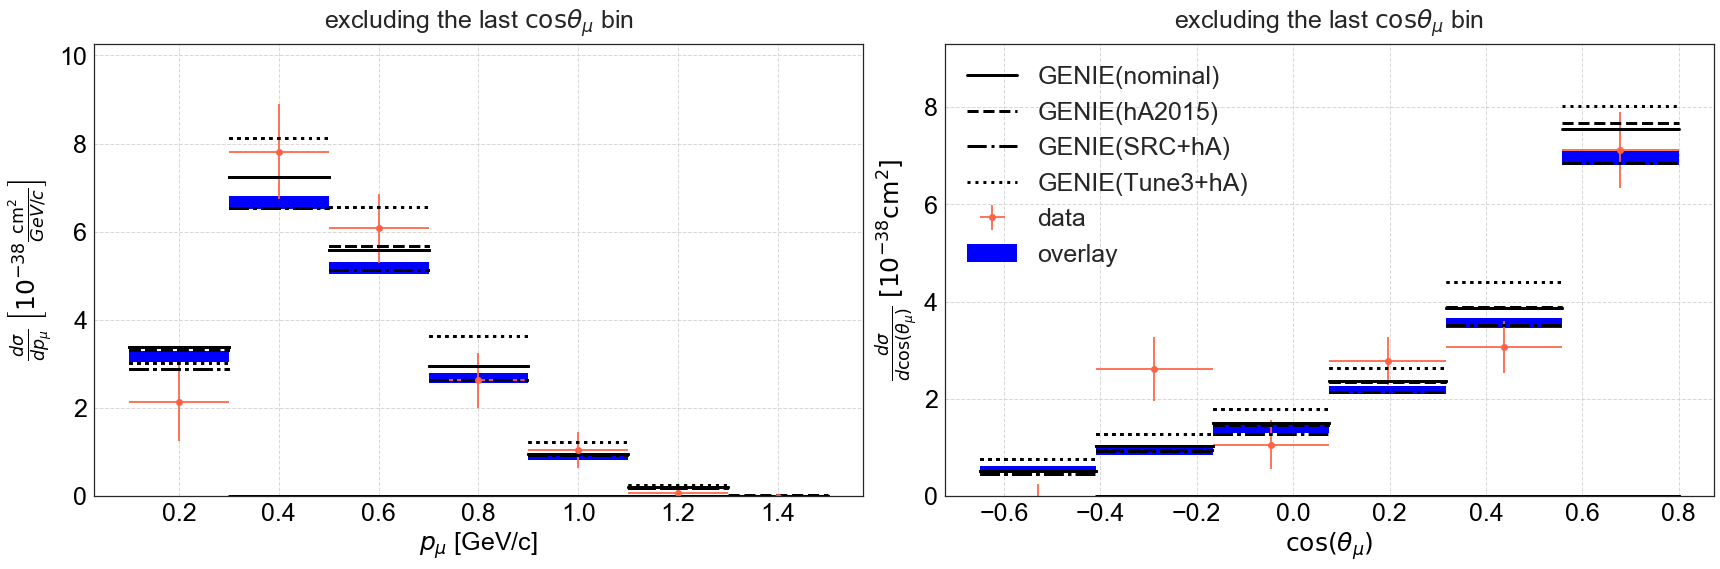

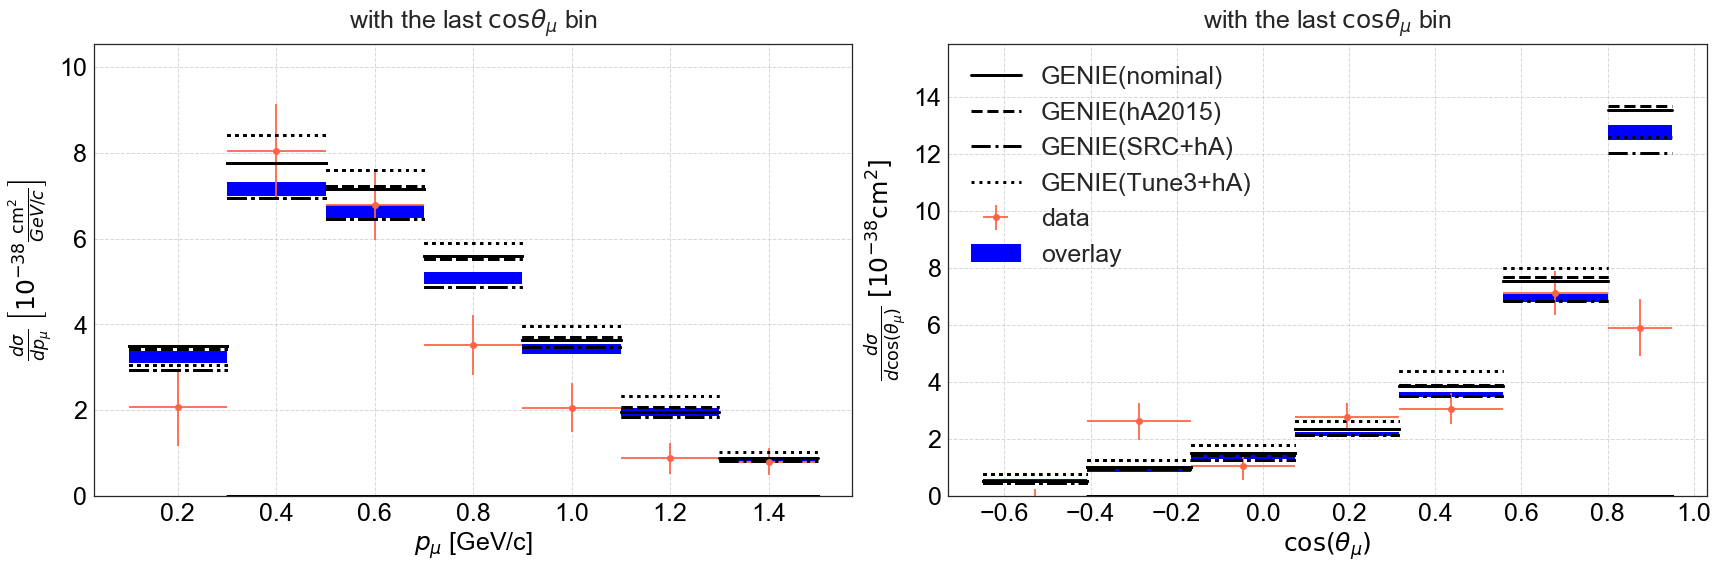

In [44]:
draw_Xsec(particle='mu',do_last_ctu_bin=True)

loading /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/1d_Xsec/PpXsecs_1D.txt
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_v8.11/Xsec_1D_p_without_last_ctu_bin.pdf
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_v8.11/Xsec_1D_p_with_last_ctu_bin.pdf


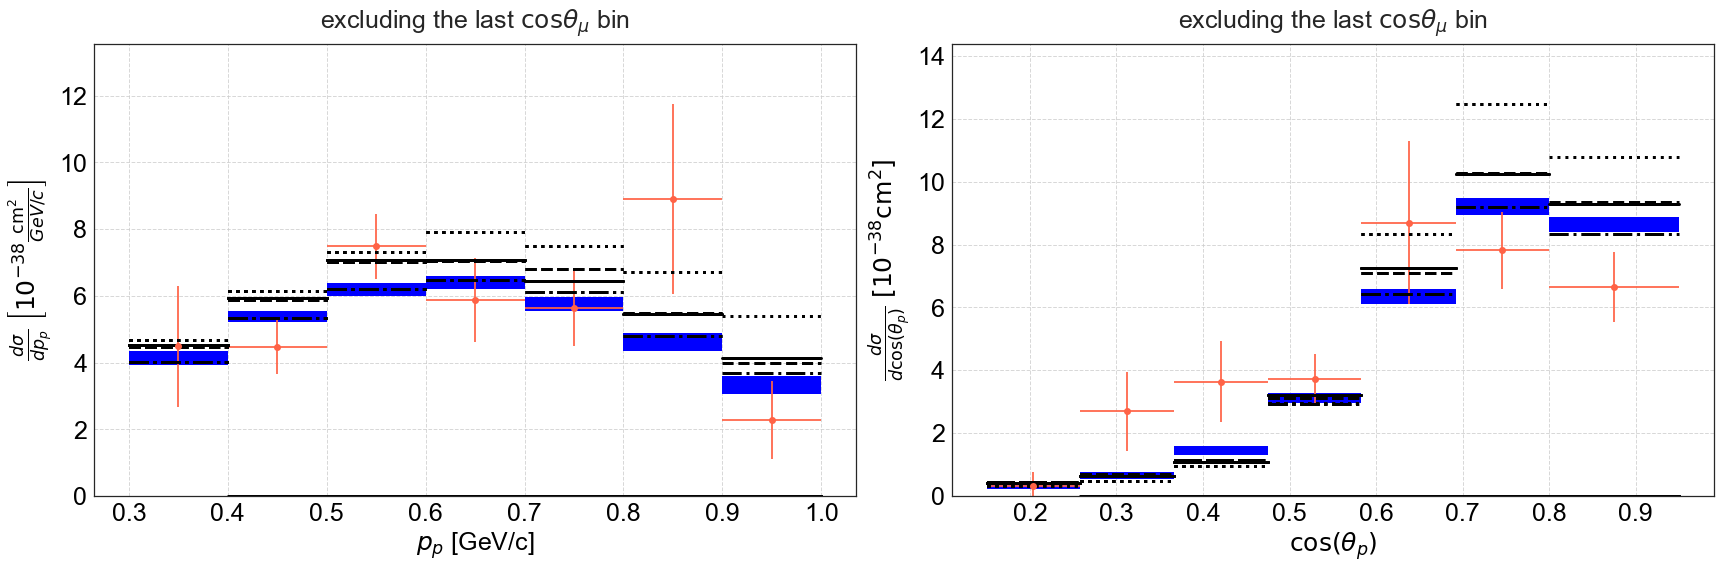

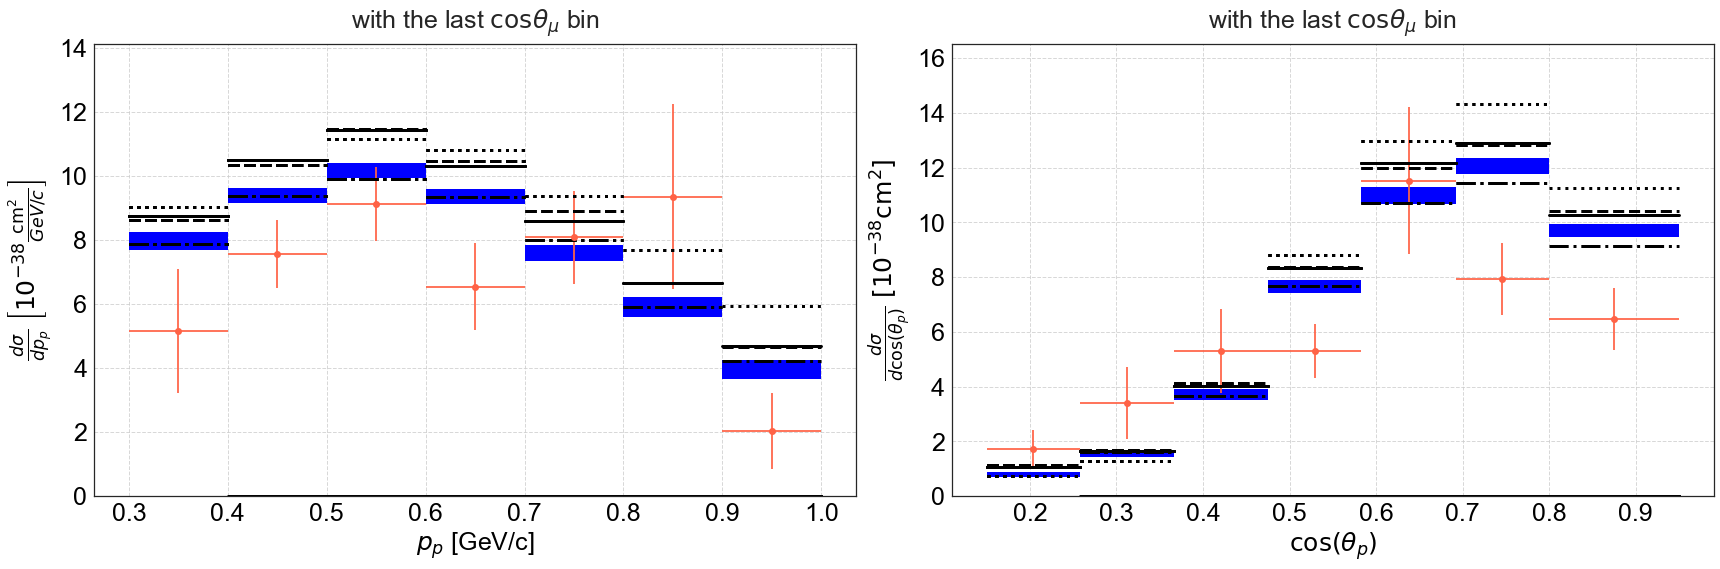

In [45]:
draw_Xsec(particle='p',do_last_ctu_bin=True)

In [48]:
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected overlay files from , loading them...
9538 selected CC1p events overlay
found  462 selected on beam and 15 beam off events...
found selected genie CC1p...


saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_v8.11/reco_Ev_Xsec.pdf


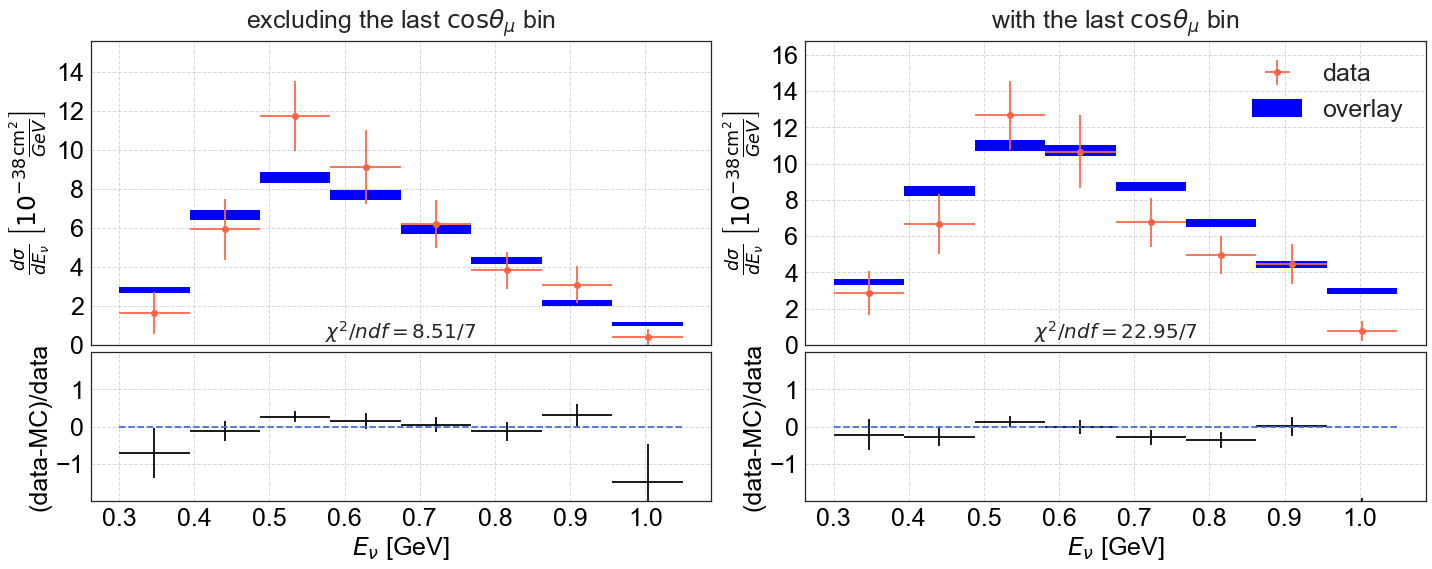

In [49]:
draw_Xsec_variable(var='reco_Ev',bins=linspace(0.3,1.05,9),vlabel=r'E_{\nu}',units='GeV',figures_path=figures_path,
                   wname='Pmu weight',
                   residuals_ylim=[-2,2],residuals_yticks=[-1,0,1],residuals_xtitle='center',
                   selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,                           
                   selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p,debug=0
                  );